# **TAREFA - MODELAGEM DE CLASSIFICAÇÃO**
### *Case: Pedidos de Refeições* (base de dados: Pedidos_Refeicoes.txt)
##### Uma empresa de tecnologia, atuante no ramo de entrega de refeições solicitadas por aplicativo, deseja entender quais os perfis de consumidores que declaram ser influenciados pela nota de avaliação dos restaurantes no momento de realizarem seu pedido. Para isso, coletaram informações transacionais e realizaram uma pesquisa com clientes que fizeram algum pedido nos últimos 30 dias.
##### As seguintes variáveis estão disponíveis:
* *ID_Respondente:* Código identificador do respondente da pesquisa
* *Idade:* Idade do cliente
* *Genero:* Gênero do cliente
* *Estado_Civil:* Estado civil do cliente
* *Ocupacao_Usual:* Ocupação usual do cliente
* *Renda_Mensal_Familiar:* Renda mensal familiar declarada pelo cliente
* *Grau_Educacao:* Grau de escolaridade do cliente
* *Refeicao_Mais_Frequente:* Tipo de refeição mais frequente dos pedidos realizados no último ano: café da manhã, almoço, jantar ou lanches
* *Compras_Saudaveis:* Indicação de se já fez compra de comida saudável no último ano (sim ou não)
* *Reclamacao_Atraso:* Indicação de se já fez alguma reclamação por atraso na entrega no último ano (sim ou não)
* *Avaliacao_Media_Anterior:* Nota média de avaliação dos restaurantes nos quais o cliente realizou pedidos no último ano
* *Influenciado_Por_Nota:* Resposta do cliente na pesquisa sobre ser influenciado pela nota do restaurante (sim ou não)

##### Realize uma análise exploratória da base de dados, de forma univariada e bivariada, cruzando cada *feature* com o *target*. Em seguida, utilize diferentes algoritmos de classificação para predizer a probabilidade de um cliente ser influenciado pela nota de avaliação dos restaurantes. Proponha um modelo final, como base na estimativa do seu desempenho em dados apartados, e interprete a força e sentido de discriminância de suas variáveis. Atente-se às boas práticas de modelagem vistas em aula.

##### **Entregável**: notebook do Python (extensão .ipynb) já compilado, subdividido de acordo com as seções abaixo. Comente os resultados de todas as análises conduzidas.


### CARREGAMENTO DE BIBLIOTECAS

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler                       # Balanceamento de classes
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.linear_model import LogisticRegression                          # Regressão logística
from sklearn.tree import DecisionTreeClassifier                              # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier                          # Floresta aleatória
from sklearn.ensemble import AdaBoostClassifier                              # AdaBoost
from sklearn.ensemble import GradientBoostingClassifier                      # Gradient boosting
from xgboost import XGBClassifier                                            # XGBoost
from lightgbm import LGBMClassifier                                          # LightGBM
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate   # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LEITURA DA BASE DE DADOS

In [2]:
dados = pd.read_table("../Dados/Pedidos_Refeicoes.txt", sep = "\t")

In [3]:
dados.dtypes

ID_RESPONDENTE                int64
IDADE                         int64
GENERO                       object
ESTADO_CIVIL                 object
OCUPACAO_USUAL               object
RENDA_MENSAL_FAMILIAR         int64
GRAU_EDUCACAO                object
REFEICAO_MAIS_FREQUENTE      object
COMPRAS_SAUDAVEIS            object
RECLAMACAO_ATRASO            object
AVALIACAO_MEDIA_ANTERIOR    float64
INFLUENCIADO_POR_NOTA         int64
dtype: object

In [4]:
dados

,ID_RESPONDENTE,IDADE,GENERO,ESTADO_CIVIL,OCUPACAO_USUAL,RENDA_MENSAL_FAMILIAR,GRAU_EDUCACAO,REFEICAO_MAIS_FREQUENTE,COMPRAS_SAUDAVEIS,RECLAMACAO_ATRASO,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
0,1,29,Feminino,Casado,Sem Ocupacao,5300,Graduacao,Almoco,Sim,Sim,4.5,1
1,2,37,Masculino,Casado,Empregado CLT,28100,Pos-Graduacao,Lanches,Sim,Sim,4.5,0
2,3,36,Feminino,Casado,Empregado CLT,14000,Graduacao,Cafe da manha,Nao,Nao,4.2,1
3,4,28,Masculino,Casado,Autonomo,10900,Ensino Fund./Medio,Cafe da manha,Nao,Nao,4.5,0
4,5,31,Feminino,Casado,Estudante,8100,Graduacao,Jantar,Nao,Nao,4.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2740,27,Masculino,Solteiro,Sem Ocupacao,3300,Sem Instrucao,Jantar,Nao,Nao,4.2,1
2740,2741,40,Masculino,Casado,Empregado CLT,3900,Graduacao,Almoco,Nao,Nao,4.6,1
2741,2742,34,Masculino,Casado,Empregado CLT,8700,Sem Instrucao,Almoco,Nao,Nao,4.7,1
2742,2743,48,Feminino,Casado,Empregado CLT,6200,Pos-Graduacao,Lanches,Sim,Nao,4.6,0


### ANÁLISE EXPLORATÓRIA UNIVARIADA

In [5]:
dados.describe()

,ID_RESPONDENTE,IDADE,RENDA_MENSAL_FAMILIAR,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
count,2744.000000,2744.000000,2744.000000,2744.000000,2744.000000
mean,1372.500000,32.576895,8145.007289,4.584220,0.682945
std,792.268894,10.889525,4524.974711,0.186558,0.465414
min,1.000000,18.000000,800.000000,4.000000,0.000000
25%,686.750000,25.000000,4800.000000,4.500000,0.000000
50%,1372.500000,30.000000,7300.000000,4.600000,1.000000
75%,2058.250000,38.000000,10700.000000,4.700000,1.000000
max,2744.000000,86.000000,28100.000000,4.900000,1.000000


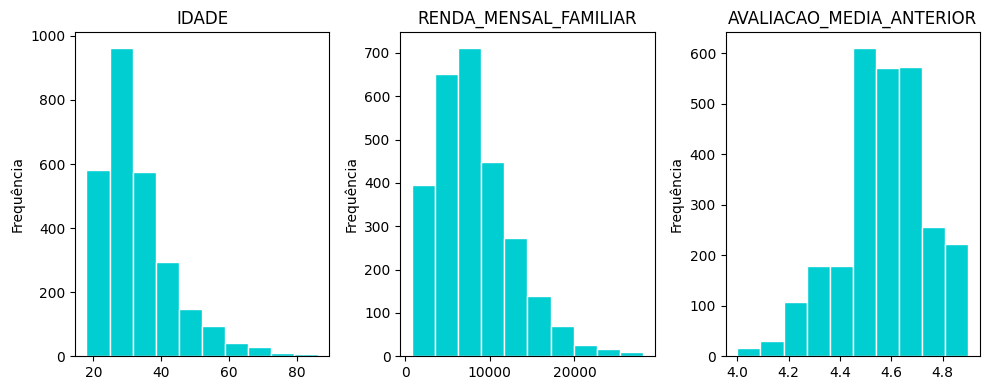

In [6]:
variaveis_numericas = dados.select_dtypes(include=['number']).columns
variaveis_numericas = variaveis_numericas.drop(['ID_RESPONDENTE','INFLUENCIADO_POR_NOTA'])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 4))

for ax, variavel in zip(axes.flat, variaveis_numericas):

  ax.hist(dados[variavel], bins = 10, color = 'darkturquoise', edgecolor = 'white')
  ax.set_title(variavel)
  ax.set_xlabel('')
  ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()


In [7]:
for coluna in dados.columns:
    if dados[coluna].dtype == 'object':  # Verifica se a coluna contém strings
        proporcoes = dados[coluna].value_counts(normalize=True) * 100
        print(f"\nProporção da coluna '{coluna}':")
        print(proporcoes)


Proporção da coluna 'GENERO':
GENERO
Masculino    56.814869
Feminino     43.185131
Name: proportion, dtype: float64

Proporção da coluna 'ESTADO_CIVIL':
ESTADO_CIVIL
Casado        50.218659
Solteiro      40.524781
Divorciado     7.397959
Viúvo          1.858601
Name: proportion, dtype: float64

Proporção da coluna 'OCUPACAO_USUAL':
OCUPACAO_USUAL
Empregado CLT    34.839650
Autonomo         26.494169
Estudante        21.064140
Sem Ocupacao     15.889213
Aposentado        1.712828
Name: proportion, dtype: float64

Proporção da coluna 'GRAU_EDUCACAO':
GRAU_EDUCACAO
Graduacao             37.281341
Ensino Fund./Medio    31.450437
Pos-Graduacao         19.351312
Sem Instrucao         11.916910
Name: proportion, dtype: float64

Proporção da coluna 'REFEICAO_MAIS_FREQUENTE':
REFEICAO_MAIS_FREQUENTE
Almoco           31.195335
Cafe da manha    29.446064
Lanches          25.655977
Jantar           13.702624
Name: proportion, dtype: float64

Proporção da coluna 'COMPRAS_SAUDAVEIS':
COMPRAS_SAUDAV

In [8]:
dados['INFLUENCIADO_POR_NOTA'].value_counts()

INFLUENCIADO_POR_NOTA
1    1874
0     870
Name: count, dtype: int64

In [9]:
dados['INFLUENCIADO_POR_NOTA'].value_counts(normalize=True) * 100

INFLUENCIADO_POR_NOTA
1    68.294461
0    31.705539
Name: proportion, dtype: float64

- Notamos que:
  - A maioria dos pedidos **são classificados como "Não Saudáveis"**
  - A minoria dos pedidos **não tem "Reclamação por atraso"**
  - A nota média de avaliação dos restaurantes em que o cliente realizou pedidos varia entre **4.0 e 4.9**, com a mediana em **4.6**
  - A maioria dos clientes **se diz "Influenciado pela Nota"** dos restaurantes, e a média de Notas dos...


### ANÁLISE EXPLORATÓRIA BIVARIADA

In [10]:
for coluna in dados.columns:
    if dados[coluna].dtype == 'object':
        print(f"\n")
        print((pd.crosstab(dados[coluna], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1))



INFLUENCIADO_POR_NOTA     0     1
GENERO                           
Feminino               31.6  68.4
Masculino              31.8  68.2


INFLUENCIADO_POR_NOTA     0     1
ESTADO_CIVIL                     
Casado                 29.5  70.5
Divorciado             31.5  68.5
Solteiro               34.2  65.8
Viúvo                  39.2  60.8


INFLUENCIADO_POR_NOTA     0     1
OCUPACAO_USUAL                   
Aposentado             38.3  61.7
Autonomo               30.9  69.1
Empregado CLT          31.4  68.6
Estudante              30.6  69.4
Sem Ocupacao           34.4  65.6


INFLUENCIADO_POR_NOTA     0     1
GRAU_EDUCACAO                    
Ensino Fund./Medio     30.9  69.1
Graduacao              31.6  68.4
Pos-Graduacao          31.8  68.2
Sem Instrucao          33.9  66.1


INFLUENCIADO_POR_NOTA       0     1
REFEICAO_MAIS_FREQUENTE            
Almoco                   23.1  76.9
Cafe da manha            31.1  68.9
Jantar                   29.3  70.7
Lanches                  44.

Comentários...

### FLUXO DE MODELAGEM

In [11]:
X = dados.drop(columns = ['INFLUENCIADO_POR_NOTA', 'ID_RESPONDENTE']) # Remover variável target, variáveis chave ou outras variáveis meramente auxiliares
y = dados['INFLUENCIADO_POR_NOTA'] # Variável target

In [12]:
X_sample = X
y_sample = y

### Balanceamento de base de dados (undersampling) e redução do tamanho da amostra, se necessário
##### Caso haja forte desbalanceamento entre as frequências das categorias da variável *target*, o balanceamento pode ajudar a proporcionar maior taxa de acerto em categorias minoritárias. Caso a base de dados seja grande mesmo após undersampling, pode-se selecionar uma sub-amostra ainda menor, para acelerar o processamento.

In [13]:
# Contagem de valores na variável resposta antes do balanceamento/redução
y.value_counts()

INFLUENCIADO_POR_NOTA
1    1874
0     870
Name: count, dtype: int64

In [14]:
rus = RandomUnderSampler(sampling_strategy = {0: 870, 1: 1305}, random_state = 123)
X_sample, y_sample = rus.fit_resample(X_sample, y_sample)

In [15]:
# Contagem de valores na variável resposta após o balanceamento/redução
y_sample.value_counts()

INFLUENCIADO_POR_NOTA
1    1305
0     870
Name: count, dtype: int64

### Tratamento de variáveis explicativas: padronização e criação de dummies
##### Nesta etapa, também chamada de pré-processamento, costuma-se **padronizar** as variáveis quantitativas (note que a padronização não é necessária para regressões ou modelos baseados em árvores) e **criar colunas dummies** para as variáveis qualitativas.

In [16]:
# Pré-processamento automático, com base nos tipos das variáveis
pre_processamento = ColumnTransformer(
    transformers = [
        # ('num', StandardScaler(), make_column_selector(dtype_include = ['int64', 'float64'])),
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

### Lista de algoritmos e hiperparâmetros testados via *random search*
##### Execute a próxima célula apenas se quiser otimizar via *random search*

In [17]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(10, 101)
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(10, 101)
    })
}

### Estimativa de desempenho por meio de validação cruzada aninhada

In [18]:
%%time
# Aplicação do pré-processamento
X_sample_transformed = pre_processamento.fit_transform(X_sample)

CPU times: user 8.58 ms, sys: 648 µs, total: 9.23 ms
Wall time: 8.72 ms


In [19]:
# Auxiliares para armazenamento do melhor modelo
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

In [31]:
%%time
# Quantidade de folds nas camadas interna e externa (substitua KFold por StratifiedKFold se necessário)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 18.1 µs


In [38]:
%%time

# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1,verbose=1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  
  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")



print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_sear

--- REGRESSÃO LOGÍSTICA ---
Média de AUC: 0.658
D.P. de AUC: 0.016
Média de Acurácia Balanceada: 0.589
D.P. de Acurácia Balanceada: 0.011
Média de Sensibilidade: 0.844
D.P. de Sensibilidade: 0.02



/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.763
D.P. de AUC: 0.031
Média de Acurácia Balanceada: 0.703
D.P. de Acurácia Balanceada: 0.024
Média de Sensibilidade: 0.805
D.P. de Sensibilidade: 0.026



/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.762
D.P. de AUC: 0.02
Média de Acurácia Balanceada: 0.681
D.P. de Acurácia Balanceada: 0.013
Média de Sensibilidade: 0.878
D.P. de Sensibilidade: 0.015



/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.9/dis

--- ADABOOST ---
Média de AUC: 0.749
D.P. de AUC: 0.012
Média de Acurácia Balanceada: 0.678
D.P. de Acurácia Balanceada: 0.009
Média de Sensibilidade: 0.88
D.P. de Sensibilidade: 0.017

--- GRADIENT BOOSTING ---
Média de AUC: 0.775
D.P. de AUC: 0.028
Média de Acurácia Balanceada: 0.708
D.P. de Acurácia Balanceada: 0.021
Média de Sensibilidade: 0.85
D.P. de Sensibilidade: 0.019

--- XGBOOST ---
Média de AUC: 0.772
D.P. de AUC: 0.026
Média de Acurácia Balanceada: 0.706
D.P. de Acurácia Balanceada: 0.019
Média de Sensibilidade: 0.831
D.P. de Sensibilidade: 0.017

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fi

### Ajuste de modelo final na base de desenvolvimento, usando validação cruzada



In [27]:
# Quantidade de folds (substitua KFold por StratifiedKFold se necessário)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [28]:
# Métricas de interesse
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

In [29]:
%%time
# Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
# modelo_final = GridSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

Comentários...

### CONCLUSÕES FINAIS

Conclusões...